In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv1D, MaxPooling2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, add, Cropping2D, ReLU, BatchNormalization, Lambda, PReLU
from tensorflow.keras.layers import Concatenate, Reshape, MaxPooling1D, Cropping1D, ZeroPadding1D, Flatten
from tensorflow.keras.layers import AveragePooling2D, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence, OrderedEnqueuer
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import activations
from tensorflow.keras.backend import expand_dims

import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import random

devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)
#tf.keras.backend.set_floatx('float16')

In [2]:
height_x = 120
width_x = 133
channels = 3
shape_x = (height_x, width_x, channels)
width_y = 27
shape_y = (height_x, width_y, channels)

data_num = 1
data_dir = f"../../datasets/dataset_0{data_num}/quarter/"
name = "recurent-v2"

activation = 'relu'
regularizer = regularizers.l1(1e-9)
dropout_ratio = 0.25

batch_size = 32
epochs = 150
learning_rate = 1e-4

workers = 4

# Part One: The Line

## Data

In [3]:
class DataGenerator(Sequence):

    def __init__(self, list_IDs, batch_size=4,
                    n_channels=1, n_classes=1, shuffle=True):
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            indexes.append(i)

        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        return 0

    def __data_generation(self, list_IDs_temp):
        Y = []
        X = []
        for i, filename in enumerate(list_IDs_temp):
            if re.search("\.(jpg|jpeg)", filename):
                filepath = os.path.join(data_dir+'X', filename)
                image_x = pyplot.imread(filepath)
                filepath = os.path.join(data_dir+'Y', filename)
                image_y = pyplot.imread(filepath)
                if len(image_y.shape) > 2 and len(image_x.shape) > 2:
                    Y.append(image_y[:,0,:])
                    X.append(image_x)
                    
        Y = (1./255) * np.array(Y)
        X = (1./255) * np.array(X)
        return X, Y

## Model

In [4]:
def block(input, kernels):
    x = Conv2D(kernels, kernel_size=1, strides=(1,1), padding='same')(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(kernels, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x_0 = Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same')(input)
    x_0 = BatchNormalization()(x_0)

    x = add([x,x_0])
    x = ReLU()(x)
    return x

input_x = Input(shape=shape_x)
x = Lambda(lambda x: x[:,:,-120:,:])(input_x)

x = Conv2D(64, kernel_size=7, strides=(1,1))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)

for i in range(4):
    for j in range(3):
        x = block(x, 64 * (2**i))
    x = MaxPooling2D()(x)

x = AveragePooling2D()(x)
x = Flatten()(x)
x = Dense(360, activation='relu', activity_regularizer=regularizer)(x)

x = Reshape((120,3))(x)

autoencoder = Model(input_x, x)
autoencoder.summary()

Model: &quot;model&quot;
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 133, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 120, 120, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 114, 114, 64) 9472        lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 114, 114, 64) 256         conv2d[0][0]                     
____________________________________________________________________________________

In [5]:
adam = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=adam, loss='mean_squared_error')

## Training

In [6]:
files = os.listdir(data_dir+'X')
gen_loader = DataGenerator(files, batch_size=batch_size)
autoencoder.fit(gen_loader, epochs=epochs, steps_per_epoch=1000,
            use_multiprocessing=True, workers=workers, shuffle=True)

Epoch 1/150
1000/1000 [==============================] - 246s 246ms/step - loss: 0.0754
Epoch 2/150
1000/1000 [==============================] - 248s 248ms/step - loss: 0.0357
Epoch 3/150
1000/1000 [==============================] - 247s 247ms/step - loss: 0.0294
Epoch 4/150
1000/1000 [==============================] - 248s 248ms/step - loss: 0.0261
Epoch 5/150
1000/1000 [==============================] - 249s 249ms/step - loss: 0.0240
Epoch 6/150
1000/1000 [==============================] - 250s 250ms/step - loss: 0.0214
Epoch 7/150
1000/1000 [==============================] - 251s 251ms/step - loss: 0.0199
Epoch 8/150
1000/1000 [==============================] - 247s 247ms/step - loss: 0.0180
Epoch 9/150
1000/1000 [==============================] - 240s 240ms/step - loss: 0.0171
Epoch 10/150
1000/1000 [==============================] - 248s 248ms/step - loss: 0.0160
Epoch 11/150
1000/1000 [==============================] - 248s 248ms/step - loss: 0.0151
Epoch 12/150
1000/1000 [======

&lt;tensorflow.python.keras.callbacks.History at 0x7f90ec7cfac0&gt;

In [6]:
#autoencoder.save_weights('saved_models/'+name)

In [6]:
autoencoder.load_weights('saved_models/'+name)

&lt;tensorflow.python.training.tracking.util.CheckpointLoadStatus at 0x7f0b4926e490&gt;

## Results

(120, 3)


&lt;matplotlib.image.AxesImage at 0x7f0a5c396d90&gt;

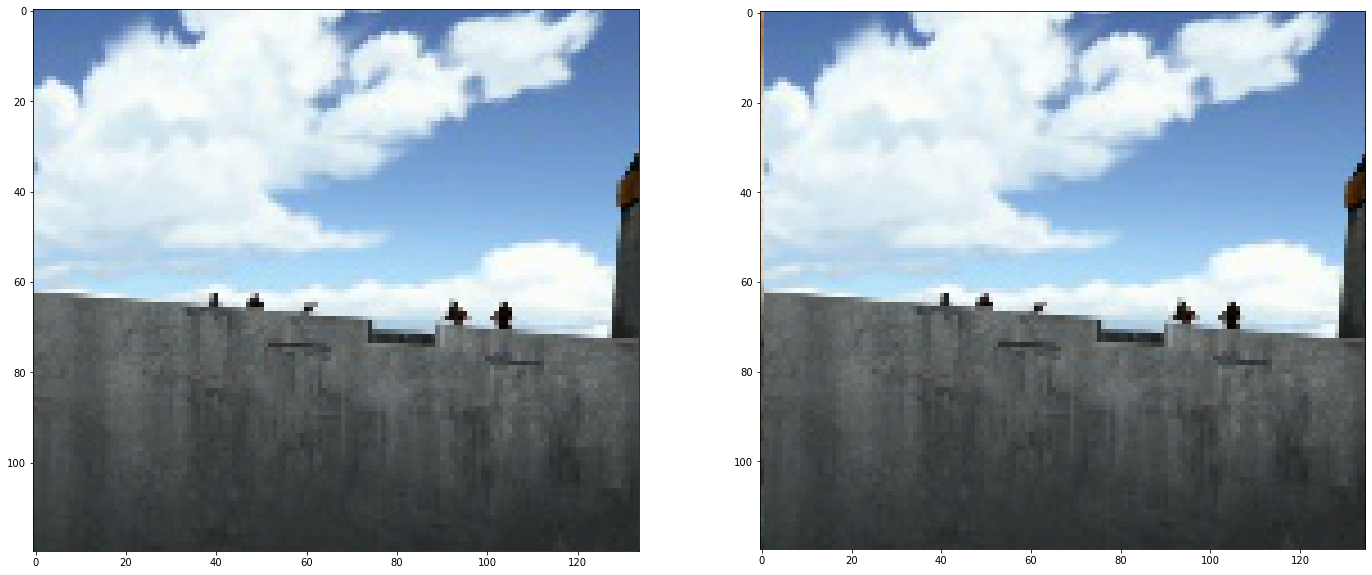

In [7]:
random_names = os.listdir(data_dir+'X')
image_name = random_names[random.randint(0, len(random_names))]
image_x = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'X', image_name)), dtype=float)
image_y_true = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'Y', image_name)), dtype=float)[:,0,:]
print(image_y_true.shape)
image_y_true = np.expand_dims(image_y_true, axis=1)
image_y_pred = autoencoder.predict(np.expand_dims(image_x, 0))[0]
image_y_pred = np.expand_dims(image_y_pred, axis=1)
image_y_pred_flip = autoencoder.predict(np.expand_dims(np.flip(image_x, axis=1), 0))[0]
image_y_pred_flip = np.flip(image_y_pred_flip, axis=1)
image_y_pred_flip = np.expand_dims(image_y_pred_flip, axis=1)
image_true = np.concatenate((image_x, image_y_true), axis=1)
image_pred = np.concatenate((image_x, image_y_pred), axis=1)
image_pred = np.concatenate((image_y_pred_flip, image_pred), axis=1)
plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(image_true)
ax = plt.subplot(10, 10, 2)
plt.imshow(image_pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


&lt;matplotlib.image.AxesImage at 0x7f0a0c7f32e0&gt;

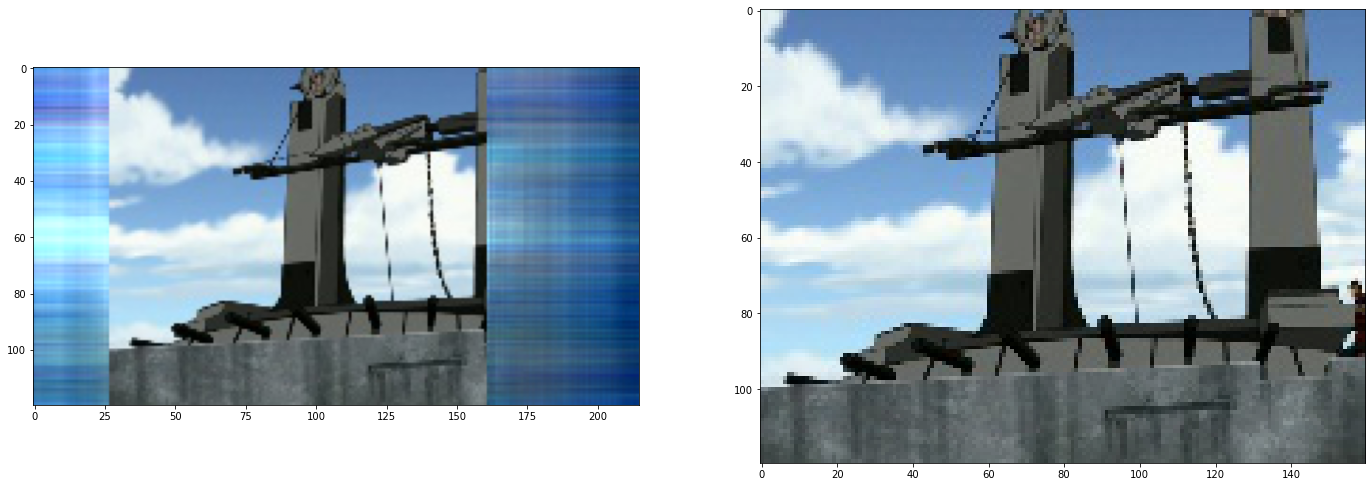

In [17]:
random_names = os.listdir(data_dir+'X')
image_name = random_names[random.randint(0, len(random_names))]
image_x = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'X', image_name)), dtype=float)
image_x_true = image_x
image_x_flip = np.flip(image_x, axis=1)
image_y_true = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'Y', image_name)), dtype=float)
slices = []
slices_flip = []
image_y_flip = np.expand_dims(image_x_flip[:,-1,:], axis=1)

for i in range(0, 2*27):
    #slice_y = np.expand_dims(slices[-1], axis=1)
    slice_y = autoencoder.predict(np.expand_dims(image_x[:,i:,:], 0))[0]
    slice_y = np.expand_dims(slice_y, axis=1)
    slices.append(slice_y)
    image_x = np.concatenate((image_x, slice_y), axis=1)

for i in range(27):
    slice_y = autoencoder.predict(np.expand_dims(image_x_flip[:,i:,:], 0))[0]
    slice_y = np.expand_dims(slice_y, axis=1)
    slices_flip.append(slice_y)
    image_x_flip = np.concatenate((image_x_flip, slice_y), axis=1)
    image_y_flip = np.concatenate((image_y_flip, slice_y), axis=1)
image_y_flip = np.flip(image_y_flip, axis=1)

image_true = np.concatenate((image_x_true, image_y_true), axis=1)

image_x = np.concatenate((image_y_flip, image_x), axis=1)

plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(image_x)
ax = plt.subplot(10, 10, 2)
plt.imshow(image_true)

# Part 2: Sequence

## Data

In [7]:
class DataGenerator2(Sequence):

    def __init__(self, list_IDs, batch_size=4,
                    n_channels=1, n_classes=1, shuffle=True):
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            indexes.append(i)

        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        return 0

    def __data_generation(self, list_IDs_temp):
        Y = []
        X = []
        for i, filename in enumerate(list_IDs_temp):
            if re.search("\.(jpg|jpeg)", filename):
                filepath = os.path.join(data_dir+'X', filename)
                image_x = pyplot.imread(filepath)
                filepath = os.path.join(data_dir+'Y', filename)
                image_y = pyplot.imread(filepath)
                if len(image_y.shape) > 2 and len(image_x.shape) > 2:
                    Y.append(image_y)
                    X_images = []
                    for i in range(27):
                        temp = np.concatenate((image_x[:,i:,:], image_y[:,:i,:]), axis=1)
                        X_images.append(temp)
                    X_images = np.array(X_images)
                    X.append(X_images)
                    
        Y = (1./255) * np.array(Y)
        X = (1./255) * np.array(X)

        X = np.array(X)
        Y = np.swapaxes(Y,1,2)

        return X, Y

## Model

In [8]:
from keras import Sequential
#input_x = Input(shape=(27, height_x, width_x, channels))
model = Sequential()
model.add(
    TimeDistributed(autoencoder, input_shape=(27, height_x, width_x, channels))
)
model.summary()

Model: &quot;sequential&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 27, 120, 3)        31857128  
Total params: 31,857,128
Trainable params: 31,799,400
Non-trainable params: 57,728
_________________________________________________________________


In [9]:
model.compile(optimizer=adam, loss='mean_squared_error')

## Training

In [10]:
files = os.listdir(data_dir+'X')
gen_loader2 = DataGenerator2(files, batch_size=1)
model.fit(gen_loader2, epochs=epochs//10, steps_per_epoch=1000,
            use_multiprocessing=True, workers=workers, shuffle=True)

Epoch 1/15
1000/1000 [==============================] - 434s 434ms/step - loss: 0.0294
Epoch 2/15
1000/1000 [==============================] - 450s 450ms/step - loss: 0.0210
Epoch 3/15
1000/1000 [==============================] - 451s 451ms/step - loss: 0.0184
Epoch 4/15
1000/1000 [==============================] - 428s 428ms/step - loss: 0.0185
Epoch 5/15
1000/1000 [==============================] - 434s 434ms/step - loss: 0.0146
Epoch 6/15
1000/1000 [==============================] - 443s 443ms/step - loss: 0.0161
Epoch 7/15
1000/1000 [==============================] - 436s 436ms/step - loss: 0.0133
Epoch 8/15
1000/1000 [==============================] - 430s 430ms/step - loss: 0.0146
Epoch 9/15
1000/1000 [==============================] - 433s 433ms/step - loss: 0.0135
Epoch 10/15
1000/1000 [==============================] - 435s 435ms/step - loss: 0.0131
Epoch 11/15
1000/1000 [==============================] - 432s 432ms/step - loss: 0.0153
Epoch 12/15
1000/1000 [==================

&lt;tensorflow.python.keras.callbacks.History at 0x7f1e7423efd0&gt;

In [14]:
random_names = os.listdir(data_dir+'X')
image_name = random_names[random.randint(0, len(random_names))]
image_x = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'X', image_name)), dtype=float)
image_y_true = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'Y', image_name)), dtype=float)
image_true = np.concatenate((image_x, image_y_true), axis=1)
#for i in range(27):
#y = model(np.repeat(np.expand_dims(image_x,axis=0),image_x,axis=0))
#test = np.repeat(np.expand_dims(image_x,axis=0),image_x,axis=0)
image_x = np.expand_dims(image_x,axis=0)
zeros = np.zeros_like(image_x)
for i in range(26):
    image_x = np.concatenate((image_x,zeros),axis=0)
image_x = np.expand_dims(image_x, axis=0)
#print(image_x.shape)
for i in range(27):
    y = model(image_x)
    for j in range(26, 0, -1):
        image_x[:,j,:,:,:] = image_x[:,j-1,:,:,:]
    slice_y = y[0,0,:,:]
    slice_y = np.expand_dims(slice_y, axis=1)
    slice_y = np.expand_dims(slice_y, axis=0)
    image_temp = image_x[:,0,:,:,:]
    #print(slice_y.shape)
    #print(image_temp.shape)
    image_temp = np.concatenate((image_temp, slice_y), axis=2)
    image_temp = image_temp[:,:,1:,:]
    image_x[:,0,:,:,:] = image_temp
    

print(y.shape)

#image_pred = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'X', image_name)), dtype=float)

plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(image_true)
ax = plt.subplot(10, 10, 2)
plt.imshow(image_x[:,0,:,:,:][0])

NameError: name &#39;model&#39; is not defined

In [17]:
images_x, slices_y = gen_loader2.__getitem__(6)
slices_y = np.swapaxes(slices_y, 1,2)

slices_pred = model(images_x)
slices_pred = np.swapaxes(slices_pred, 1,2)

image_true = np.concatenate((images_x[0][0], slices_y[0]), axis=1)
image_pred = np.concatenate((images_x[0][0], slices_pred[0]), axis=1)

plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(image_true)
ax = plt.subplot(10, 10, 2)
plt.imshow(image_pred)

NameError: name &#39;gen_loader2&#39; is not defined

# Part 2-v2

## Data

In [9]:
class DataGenerator3(Sequence):

    def __init__(self, list_IDs, batch_size=4,
                    n_channels=1, n_classes=1, shuffle=True):
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            indexes.append(i)

        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        return 0

    def __data_generation(self, list_IDs_temp):
        Ys = []
        for i in range(27):
            Ys.append([])
        X = []
        for i, filename in enumerate(list_IDs_temp):
            if re.search("\.(jpg|jpeg)", filename):
                filepath = os.path.join(data_dir+'X', filename)
                image_x = pyplot.imread(filepath)
                filepath = os.path.join(data_dir+'Y', filename)
                image_y = pyplot.imread(filepath)
                if len(image_y.shape) > 2 and len(image_x.shape) > 2:
                    X.append(image_x)
                    for i in range(27):
                        Ys[i].append(image_y[:,i,:])
                    
        X = (1./255) * np.array(X)
        for i in range(27):
            Ys[i] = (1./255) * np.array(Ys[i])
        return X, Ys

## Model

#### V1

In [11]:
def inception(inline, outline):
    input_1 = expand_dims(outline, axis=2)
    input_2 = Lambda(lambda x: x[:,:,1:,:])(inline)
    ret_input = Concatenate(axis=2)([input_2,input_1])
    ret_output = autoencoder(ret_input)
    return ret_input, ret_output

input1 = Input(shape=shape_x)
output1 = autoencoder(input1)

inputs = [input1]
outputs = [output1]

for i in range(26):
    ret_in, ret_out = inception(inputs[-1], outputs[-1])
    inputs.append(ret_in)
    outputs.append(ret_out)

for i in range(27):
    outputs[i] = expand_dims(outputs[i], axis=2)

cat = Concatenate(axis=2)([outputs[0], outputs[1]])

for i in range(2, 27):
    cat = Concatenate(axis=2)([cat, outputs[i]])
#input2_1 = expand_dims(output1, axis=2)
#input2_2 = Lambda(lambda x: x[:,:,1:,:])(input1)
#input2 = Concatenate(axis=2)([input2_2,input2_1])
#output2 = autoencoder(input2)
#
#input3_1 = expand_dims(output2, axis=2)
#input3_2 = Lambda(lambda x: x[:,:,1:,:])(input2)
#input3 = Concatenate(axis=2)([input3_2,input3_1])
#output3 = autoencoder(input3)

newmodel = Model(input1, cat)
newmodel.summary()

Model: &quot;model_1&quot;
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 133, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 120, 3)       31857128    input_2[0][0]                    
                                                                 concatenate[0][0]                
                                                                 concatenate_1[0][0]              
                                                                 concatenate_2[0][0]              
                                                                 concatenate_3[0][0]              
                                                                 concatenate_4[0][

#### v2

In [10]:
def inception(inline, outline):
    input_1 = expand_dims(outline, axis=2)
    input_2 = Lambda(lambda x: x[:,:,1:,:])(inline)
    ret_input = Concatenate(axis=2)([input_2,input_1])
    ret_output = autoencoder(ret_input)
    return ret_input, ret_output

input1 = Input(shape=shape_x)
output1 = autoencoder(input1)

inputs = [input1]
outputs = [output1]

for i in range(26):
    ret_in, ret_out = inception(inputs[-1], outputs[-1])
    inputs.append(ret_in)
    outputs.append(ret_out)

newmodel = Model(input1, outputs)
newmodel.summary()

Model: &quot;model_1&quot;
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 133, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 120, 3)       31857128    input_2[0][0]                    
                                                                 concatenate[0][0]                
                                                                 concatenate_1[0][0]              
                                                                 concatenate_2[0][0]              
                                                                 concatenate_3[0][0]              
                                                                 concatenate_4[0][

In [11]:
adam = Adam(learning_rate=learning_rate)
newmodel.compile(optimizer=adam, loss='mean_squared_error')

In [12]:
files = os.listdir(data_dir+'X')
gen_loader3 = DataGenerator3(files, batch_size=1)
newmodel.fit(gen_loader3, epochs=epochs//10, steps_per_epoch=1000,
            use_multiprocessing=True, workers=workers, shuffle=True)

Epoch 1/15
1000/1000 [==============================] - 775s 775ms/step - loss: 1.6430 - model_loss: 0.0606 - model_1_loss: 0.0616 - model_2_loss: 0.0548 - model_3_loss: 0.0541 - model_4_loss: 0.0549 - model_5_loss: 0.0554 - model_6_loss: 0.0556 - model_7_loss: 0.0551 - model_8_loss: 0.0562 - model_9_loss: 0.0567 - model_10_loss: 0.0586 - model_11_loss: 0.0585 - model_12_loss: 0.0597 - model_13_loss: 0.0602 - model_14_loss: 0.0611 - model_15_loss: 0.0614 - model_16_loss: 0.0628 - model_17_loss: 0.0626 - model_18_loss: 0.0641 - model_19_loss: 0.0637 - model_20_loss: 0.0646 - model_21_loss: 0.0648 - model_22_loss: 0.0663 - model_23_loss: 0.0656 - model_24_loss: 0.0678 - model_25_loss: 0.0666 - model_26_loss: 0.0696
Epoch 2/15
1000/1000 [==============================] - 777s 777ms/step - loss: 0.9729 - model_loss: 0.0433 - model_1_loss: 0.0429 - model_2_loss: 0.0293 - model_3_loss: 0.0302 - model_4_loss: 0.0303 - model_5_loss: 0.0315 - model_6_loss: 0.0318 - model_7_loss: 0.0319 - model_

KeyboardInterrupt: 

In [13]:
random_names = os.listdir(data_dir+'X')
image_name = random_names[random.randint(0, len(random_names))]
image_x = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'X', image_name)), dtype=float)
image_y_true = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'Y', image_name)), dtype=float)
image_ys_pred = newmodel(np.expand_dims(image_x,axis=0))
image_y_pred = []
for i in range(27):
    image_y_pred.append(image_ys_pred[i][0])
image_y_pred = np.array(image_y_pred)

image_true = np.concatenate((image_x, image_y_true), axis=1)
image_pred = np.concatenate((image_x, image_y_pred), axis=1)

plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(image_true)
ax = plt.subplot(10, 10, 2)
plt.imshow(image_pred)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 120 and the array at index 1 has size 27

In [11]:
random_names = os.listdir(data_dir+'X')
image_name = random_names[random.randint(0, len(random_names))]
image_x = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'X', image_name)), dtype=float)
image_y_true = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'Y', image_name)), dtype=float)
image_y_pred = newmodel(np.expand_dims(image_x,axis=0))

image_true = np.concatenate((image_x, image_y_true), axis=1)
image_pred = np.concatenate((image_x, image_y_pred[0]), axis=1)

plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(image_true)
ax = plt.subplot(10, 10, 2)
plt.imshow(image_pred)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 120 and the array at index 1 has size 1

In [23]:
files = os.listdir(data_dir+'X')
gen_loader3 = DataGenerator3(files, batch_size=2)
images_x, images_y = gen_loader3.__getitem__(6)
print(images_x.shape)
print(len(images_y))
print(images_y[1].shape)

(2, 120, 133, 3)
27
(2, 120, 3)


In [24]:
print(len(newmodel.outputs))

28
